In [17]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from textblob import TextBlob
import yfinance as yf
import json


In [18]:
with open('config.json', 'r') as f:
    config = json.load(f)
API_KEY = config["API_KEY"]

In [19]:

def fetch_stock_data(symbol, period='1mo'):
    stock_data = yf.download(symbol, period=period)
    return stock_data['Close']

def safe_fetch_news_articles(symbol, start_date, end_date):
    try:
        return fetch_news_articles(symbol, start_date, end_date)
    except Exception as e:
        print(f"Error fetching news articles for {symbol}: {str(e)}")
        return []

def fetch_news_articles(symbol, start_date, end_date):
    url = (f'https://newsapi.org/v2/everything?q={symbol}&from={start_date}&to={end_date}'
           f'&sortBy=publishedAt&apiKey={API_KEY}')
    response = requests.get(url)
    if response.status_code == 200:
        return response.json().get('articles', [])
    else:
        raise Exception(f"API Error: {response.text}")

def fetch_and_analyze(symbol):
    stock_data = fetch_stock_data(symbol)
    dates = stock_data.index.strftime('%Y-%m-%d').tolist()
    stock_prices = stock_data.tolist()

    articles = fetch_news_articles(symbol, dates[0], dates[-1])
    sentiments_data = analyze_sentiment(articles)

    date_sentiments = {}
    for s in sentiments_data:
        date = s['date'].split("T")[0]
        sentiment_val = 1 if s['sentiment'] == 'positive' else -1 if s['sentiment'] == 'negative' else 0
        date_sentiments.setdefault(date, []).append(sentiment_val)
    
    sentiments = []
    for date in dates:
        numerical_sentiments = date_sentiments.get(date, [])
        avg_sentiment = sum(numerical_sentiments) / len(numerical_sentiments) if numerical_sentiments else 0
        sentiments.append(avg_sentiment)
    
    return {
        'dates': dates,
        'stock_prices': stock_prices,
        'sentiments': sentiments
    }


In [20]:

API_KEY = API_KEY 

def fetch_stock_data(symbol, period='1mo'):
    stock_data = yf.download(symbol, period=period)
    return stock_data['Close']

def fetch_news_articles(symbol, start_date, end_date):
    url = (f'https://newsapi.org/v2/everything?q={symbol}&from={start_date}&to={end_date}'
           f'&sortBy=publishedAt&apiKey={API_KEY}')
    response = requests.get(url)
    return response.json()['articles']

def analyze_sentiment(articles):
    sentiments = []    
    for article in articles:
        analysis = TextBlob(str(article['description']))
        polarity = analysis.sentiment.polarity
        sentiments.append({
            'date': article['publishedAt'],
            'title': article['title'],
            'description': article['description'],
            'sentiment': 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
        })
    return sentiments


In [21]:

def plot_bar_charts(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    sns.barplot(x='Stock Symbol', y='Average Stock Price', data=df, ax=axes[0], palette="viridis")
    axes[0].set_title('Average Stock Price')
    axes[0].set_ylabel('Average Stock Price')
    axes[0].set_xlabel('Stock Symbol')
    
    sns.barplot(x='Stock Symbol', y='Average Sentiment Value', data=df, ax=axes[1], palette="viridis")
    axes[1].set_title('Average Sentiment Value')
    axes[1].set_ylabel('Average Sentiment Value')
    axes[1].set_xlabel('Stock Symbol')
    
    plt.tight_layout()
    plt.show()

def plot_time_series(data):
    fig, axes = plt.subplots(len(data), 1, figsize=(12, 4 * len(data)))
    
    for i, (symbol, values) in enumerate(data.items()):
        df_temp = pd.DataFrame({
            'Date': pd.to_datetime(values['dates']),
            'Stock Price': values['stock_prices'],
            'Sentiment Value': values['sentiments']
        })
        
        ax = axes[i] if len(data) > 1 else axes
        df_temp.plot(x='Date', y='Stock Price', legend=True, ax=ax, label='Stock Price', color='blue')
        ax_twin = ax.twinx()
        df_temp.plot(x='Date', y='Sentiment Value', legend=True, ax=ax_twin, label='Sentiment Value', color='red', alpha=0.5)
        ax_twin.set_ylabel('Sentiment Value')
        ax.set_title(f'Sentiment vs Stock Price for {symbol}')
        ax.grid(True)

    fig.tight_layout()
    plt.show()

def plot_correlation(data):
    correlation_coeffs = []
    
    for symbol, values in data.items():
        df_temp = pd.DataFrame({
            'Stock Price': values['stock_prices'],
            'Sentiment Value': values['sentiments']
        })
        correlation_coeffs.append(df_temp.corr().iloc[0, 1])
    
    plt.figure(figsize=(10, 6))
    plt.bar(data.keys(), correlation_coeffs, color='skyblue')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Correlation Coefficient')
    plt.title('Correlation Coefficient of Sentiment and Stock Price for Each Stock')
    plt.grid(axis='y')
    plt.show()


In [22]:

# Fetch and process data for each stock symbol
stock_symbols = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
data = {}
for symbol in stock_symbols:
    data[symbol] = fetch_and_analyze(symbol)

# Create a DataFrame for average stock prices and sentiments
stock_list = [sum(data[symbol]['stock_prices']) / len(data[symbol]['stock_prices']) for symbol in stock_symbols]
sentiment_list = [sum(data[symbol]['sentiments']) / len(data[symbol]['sentiments']) for symbol in stock_symbols]

df = pd.DataFrame({
    'Stock Symbol': stock_symbols,
    'Average Stock Price': stock_list,
    'Average Sentiment Value': sentiment_list
})

df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Stock Symbol,Average Stock Price,Average Sentiment Value
0,AAPL,186.193915,0.052693
1,AMZN,133.974350,-0.033057
2,GOOGL,128.020869,0.039072
3,MSFT,331.515650,0.041598


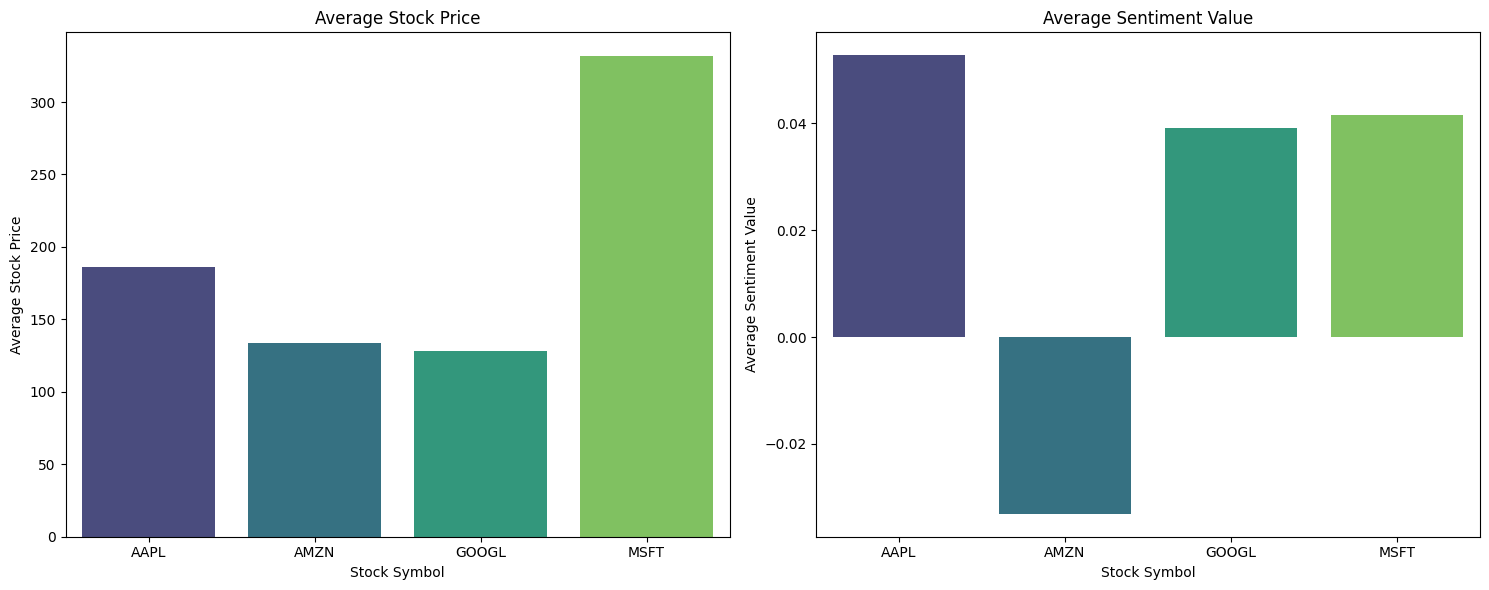

In [23]:

plot_bar_charts(df)


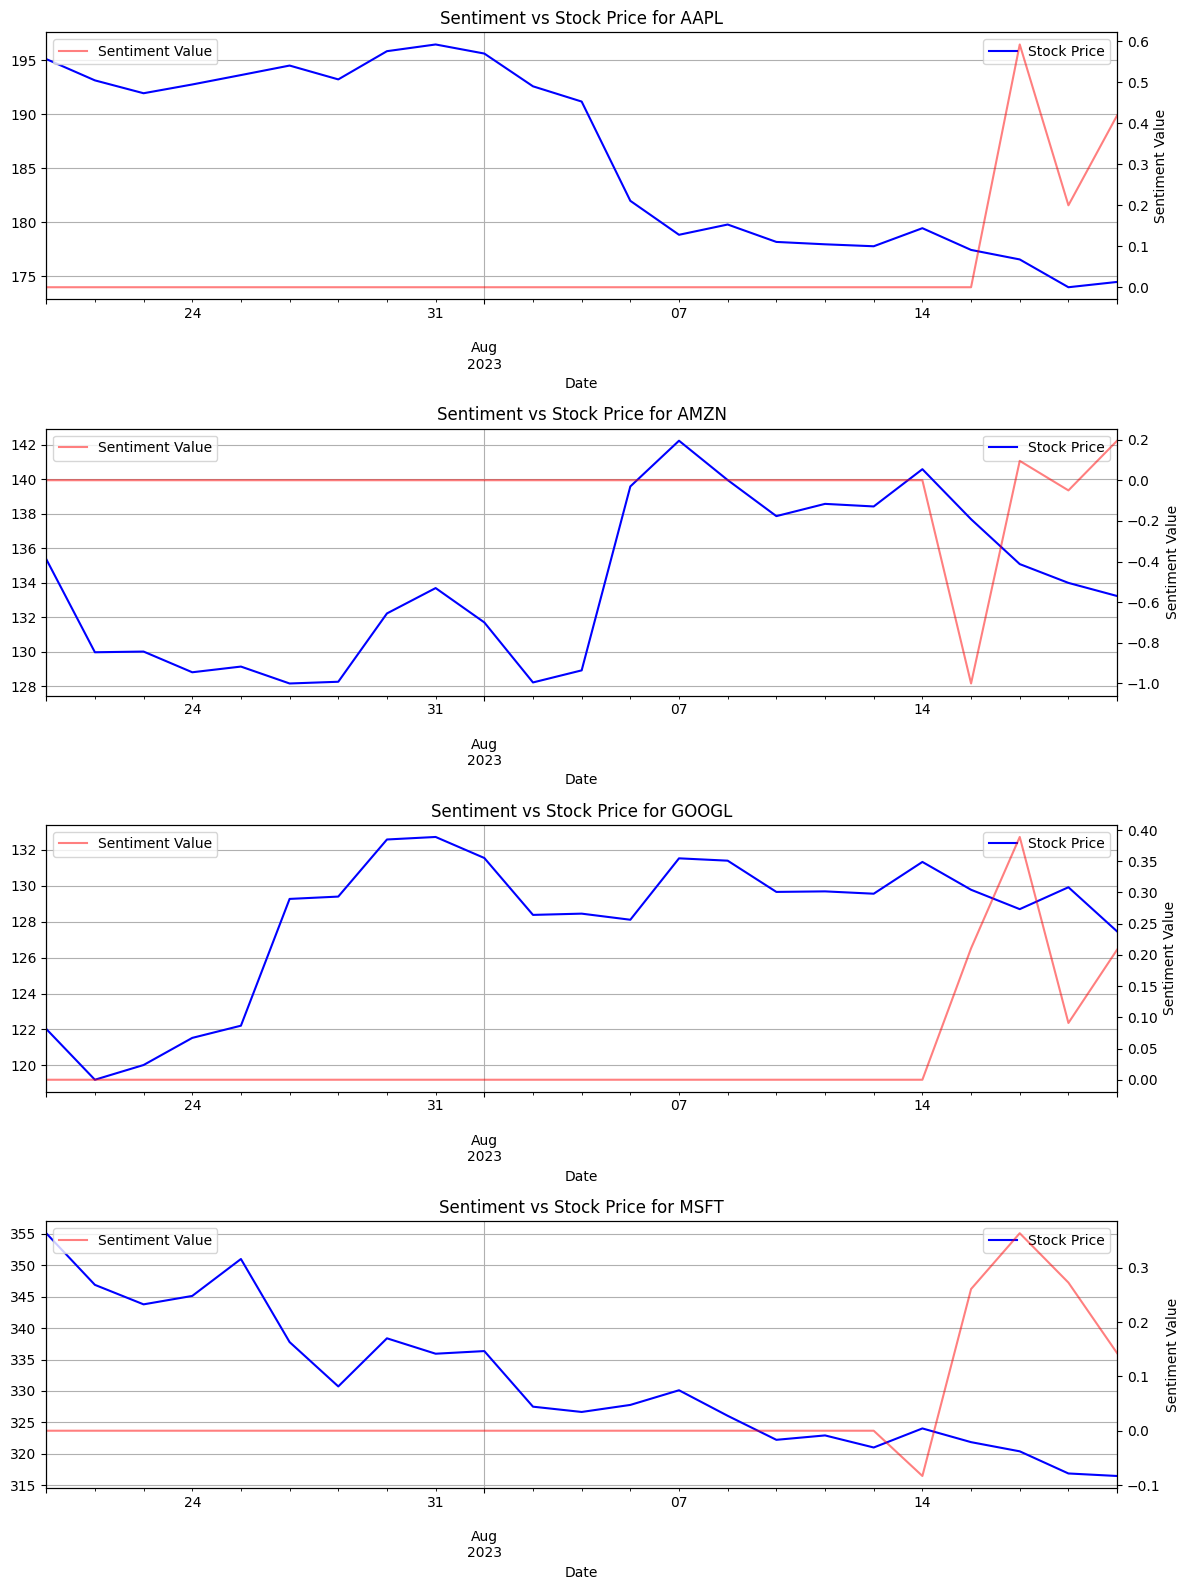

In [24]:

plot_time_series(data)


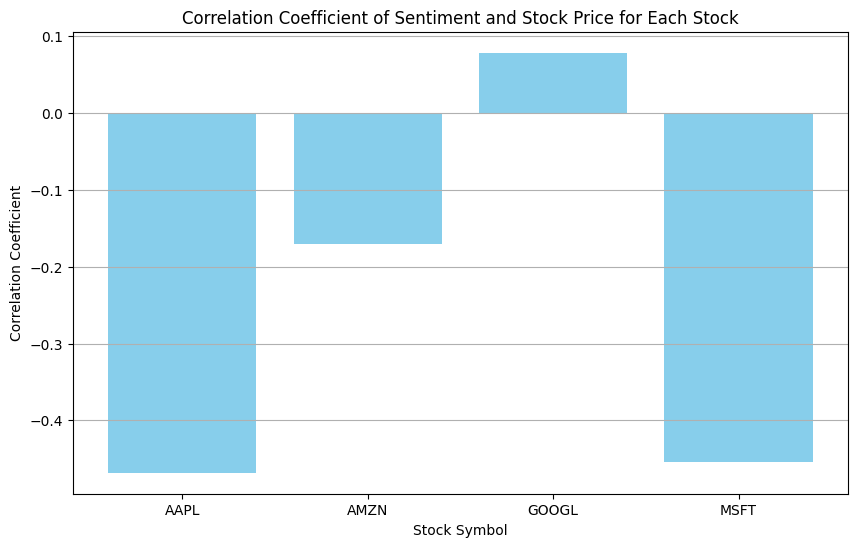

In [25]:

plot_correlation(data)
